# Data Pre-processing and Cleaning

In [1]:
#import libraries
import os
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import matplotlib.pyplot as plt

In [2]:
#set path to file location
os.chdir('C:\\Users\\Sean\\Desktop\excel_data')

In [3]:
#read file
df = pd.read_csv("14_4_2020_web_scraping.csv", index_col=0)
pd.set_option('max_colwidth',150)
df.head()

,date,drug_name,condition,rating,comment
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ..."
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo..."


In [4]:
#check for null in each column
df.isnull().sum()

date         0
drug_name    0
condition    0
rating       0
comment      0
dtype: int64

In [5]:
#make a new column 'word_count', then assign the number of word counts of comments
count = df['comment'].str.split().str.len()
df["word_count"] = count
df.head()

,date,drug_name,condition,rating,comment,word_count
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41


              rating     word_count
count  177779.000000  177779.000000
mean        6.008803      84.507237
std         3.799016      48.872547
min         0.000000       1.000000
25%         1.000000      45.000000
50%         8.000000      80.000000
75%        10.000000     124.000000
max        10.000000    1894.000000


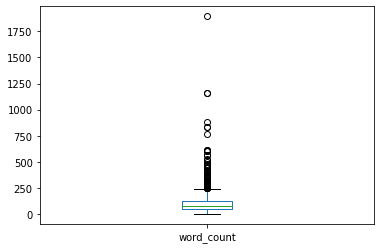

In [6]:
#generate a boxplot to check for outliers for word_count
print(df.describe())
df.boxplot("word_count", grid = False)
plt.show()

In [7]:
#get upper boundary value
IQR = 124 - 45
boundary = 124 + 1.5 * IQR
print(boundary)

242.5


In [8]:
print("total rows:" + str(len(df)))
print("rows with outliers: " + str(len(df[df.word_count > 242.5])))
print("rows without outliers:" + str(len(df[df.word_count < 242.5])))

total rows:177779
rows with outliers: 87
rows without outliers:177692


In [9]:
#remove rows for word count more than upper boundary value
df = df[df.word_count <= 242.5]
len(df)

177692

In [10]:
#remove duplicate rows with same comments
print("original number of rows:" + str(len(df)))
df.comment = df.comment.drop_duplicates(keep = "first")
df = df[df['comment'].notna()] #drop row with comment == Nan
df = df.reset_index(drop=True) #reset index as some rows were dropped
print("number of rows after remove duplicated comments:" + str(len(df)))

original number of rows:177692
number of rows after remove duplicated comments:125786


In [11]:
#assign negation_list, emotion_list and abbreviations
negate_list = ["aint", "arent", "cannot", "cant", "couldnt", " darent" , "didnt", "doesnt",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", " mustnt", "neither" ,
     "neednt", "never", "none", "nope", "nor", "not", "no", " nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "wasnt", " werent",
     "without", "wont", "rarely", "seldom", "despite"]


emotion_list = ["$:", "%)","%-)", "&-:", "&:", "( '}{' )", "(%", "('-:", "(':", "((-:", "(*", "(-%", 
                "(-*", "(-:", "(-:0", "(-:<", "(-:o", "(-:O", "(-:{", "(-:|>*", "(-;", "(-;|", "(8", 
                "(:", "(:0", "(:<", "(:o", "(:O", "(;", "(;<", "(=", "(?", "(^:", "(^;", "(^;0", "(^;o", 
                "(o:", ")':", ")-':", ")-:", ")-:<", ")-:{", "):", "):<", "):{", ");<", "*)", "*-)", "*-:", 
                "*-;", "*:", "*<|:-)", "*\0/*", "*^:", ",-:", "---'-;-{@", "--<--<@", ".-:", "..###-:", 
                "..##:", "/-:", "/:", "/:<", "/=", "/^:", "/o:", "0-8", "0-|", "0:)", "0:-)", "0:-3", "0:03", 
                "0;^)", "0_o", "3:(", "3:)", "3:-(", "3:-)", "4col", "4q", "5fs", "8)", "8-d", "8-o", "86", 
                "8d", ":###..", ":$", ":&", ":'(", ":')", ":'-(", ":'-)", ":(", ":)", ":*", ":-###..", ":-&", 
                ":-(", ":-)", ":-))", ":-*", ":-,", ":-.", ":-/", ":-<", ":-d", ":-D", ":-o", ":-p", ":-[", 
                '":-\"', ":-c", ":-p", ":-|", ":-||", ":-Þ", ":/", ":3", ":<", ":>", ":?)", ":?c", ":@", ":d", 
                ":D", ":l", ":o", ":p", ":s", ":[", '":\"', ":]", ":^)", ":^*", ":^/", '":^\"', ":^|", ":c", 
                ":c)", ":o)", ":o/", '":o\"', ":o|", ":P", ":{", ":|", ":}", ":Þ", ";)", ";-)", ";-*", ";-]", 
                ";d", ";D", ";]", ";^)", "</3", "<3", "<:", "<:-|", "=)", "=-3", "=-d", "=-D", "=/", "=3", "=d", 
                "=D", "=l", '"=\"', "=]", "=p", "=|", ">-:", ">.<", ">:", ">:(", ">:)", ">:-(", ">:-)", ">:/", 
                ">:o", ">:p", ">:[", '">:\"', ">;(", ">;)", ">_>^", "@:", "@>-->--", "@}-;-'--", "{:", "|-0", 
                "|-:", "|-:>", "|-o", "|:", "|;-)", "|=", "|^:", "|o:", "||-:", "}:", "}:(", "}:)", "}:-(", "}:-)"]

keys = range(len(emotion_list))

key_list = list(keys)
for i in key_list:
    key_list[i] = "emo" + str(i)

newdict = dict(zip(key_list, emotion_list))

emotion_dict = {y:x for x,y in newdict.items()}



abbre_dict = {"asap ": "as soon as possible", "b4": "before", "bc": "because", "bcoz": "because",
              "bf": "before", "coz": "cause", "cuz": "cause", "dr": "doctor", "drs": "doctors", 
              "mg": "milligram", "fb": "facebook", "fyi": "for your information", "frm": "from", 
              "gud": "good", "gr8": "great", "hv": "have", "idk": "i do not know", 
              "lmao": "laughing my ass off", "lol": "laughing out loud", "mom": "mother", "nvm": "never mind", 
              "omg": "oh my god", "ofc": "of course", "otc" : "over the counter", "plz": "please", "rip": "rest in peace", 
              "r": "are", "smh": "shaking my head", "tbh": "to be honest", "tbd": "to be determined", 
              "thx": "thanks", "ty": "thank you", "u": "you", "vs" : "versus", "ur": "your", "w": "with", "wo": "without", 
              "wth": "with", "yr": "year", "yrs": "years", "wat": "what",
              "jan": "january", "feb": "february", "mar": "march", "apr": "april",
              "aug": "august", "sep": "september", "oct": "october", "nov": "november", "dec": "december", 
              "adr": "adverse drug reaction", "adh": "antidiuretic hormone", "ards": "acute respiratory distress syndrome", 
              "bp": "blood pressure", "copd": "chronic obstructive pulmonary disease", "dm": "diabetes mellitus", 
              "dvt": "deep vein thrombosis", "icu": "intensive care unit", "ptsd": "post-traumatic stress syndrome", 
              "ra": "rheumatoid arthritis","co2": "carbon dioxide", "h2o": "water", "o2": "oxygen", "rbc": "red blood cell", 
              "tab": "tablet", "cpr": "cardiopulmonary resuscitation", "ecg": "electrocardiogram", "iv": "intravenous", 
              "aids": "acquired immune deficiency syndrome", "cbc": "complete blood count","gi": "gastrointestinal",
              "hiv": "human immunodeficiency virus", "tb": "tuberculosis", "uri": "upper respiratory infection", 
              "uti": "urinary tract infection","iud": "intrauterine device", "mid": "middle", 
              "fda": "food and drug administration", "rls": "restless leg syndrome"}

In [12]:
#define cleaning functions
def cleaning_function(text):
    text = contractions.fix(text) #expand contractions
    text = text.lower() #convert to lower case
    text = re.sub('\(.*?\)', '', text) #remove context between ()
    text = re.sub('\w*\d\w*', ' ', text) #remove numbers 0-9,a-Z
    text = re.sub('\n', ' ', text)
    text = re.sub('[‘’“”…]', '', text)
    return text
cleaning = lambda x: cleaning_function(x)

def cleaning_function2(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuation symbols
    return text
cleaning2 = lambda x: cleaning_function2(x)

In [13]:
# apply cleaning function
df["clean"] = df.comment.apply(cleaning)
df.head()

,date,drug_name,condition,rating,comment,word_count,clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,"""sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,"""taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight. all these hiv meds have terr..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,"""my wife and i have been on epzicom since along with viramune it works no side effects we take the generic. i do not understand why drs kee..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,"""epzicom reyataz and norvir triple combination. it is expensive but all hiv medications are expensive and there are programs to help pay for the ..."
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,"""i have used this since first diagnosed and starting haart in and it is worked extremely well: my numbers have never been below since month..."


In [14]:
#split the comments and convert emotions to their respective symbols
for i, sentence in enumerate(df.clean.str.split()):
    convert_indicator = False
    
    for index, word in enumerate(sentence):
        if word in emotion_dict:
            convert_indicator = True
            emo_word = emotion_dict.get(word)
            sentence[index] = emo_word
            
    if convert_indicator == True:
        df.clean[i] = sentence
        df.clean[i] = " ".join([char for char in df.clean[i]])
df.head()

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,date,drug_name,condition,rating,comment,word_count,clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,"""sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,"""taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight. all these hiv meds have terr..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,"""my wife and i have been on epzicom since along with viramune it works no side effects we take the generic. i do not understand why drs kee..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,"""epzicom reyataz and norvir triple combination. it is expensive but all hiv medications are expensive and there are programs to help pay for the ..."
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,"""i have used this since first diagnosed and starting haart in and it is worked extremely well: my numbers have never been below since month..."


In [15]:
#apply second cleaning function to remove punctuation, this step is done after emotion being converted to unique symbols to prevent from eliminated in this step
df.clean = df.clean.apply(cleaning2)
df.head()

,date,drug_name,condition,rating,comment,word_count,clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these hiv meds have terr...
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no side effects we take the generic i do not understand why drs kee...
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all hiv medications are expensive and there are programs to help pay for the ...
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,i have used this since first diagnosed and starting haart in and it is worked extremely well my numbers have never been below since month...


In [16]:
#expand abbreviations
for i, sentence in enumerate(df.clean.str.split()):
    convert_indicator = False
    
    for index, word in enumerate(sentence):
        if word in abbre_dict:
            convert_indicator = True
            expand_word = abbre_dict.get(word)
            sentence[index] = expand_word
            
    if convert_indicator == True:
        df.clean[i] = sentence
        df.clean[i] = " ".join([char for char in df.clean[i]])
df.head()

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,date,drug_name,condition,rating,comment,word_count,clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no side effects we take the generic i do not understand why doctors keep pre...
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,i have used this since first diagnosed and starting haart in and it is worked extremely well my numbers have never been below since month...


In [17]:
#tag negation words with "_neg"
for i, sentence in enumerate(df.clean.str.split()):
    convert_indicator = False
    
    for index, word in enumerate(sentence):
        if word in negate_list:
            convert_indicator = True
            neg_word = word + "_neg"
            sentence[index] = neg_word
            
    if convert_indicator == True:
        df.clean[i] = sentence
        df.clean[i] = " ".join([char for char in df.clean[i]])
        
df.head()

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,date,drug_name,condition,rating,comment,word_count,clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,i have used this since first diagnosed and starting haart in and it is worked extremely well my numbers have never_neg been below since months aft...


In [18]:
#remove Ascii character
def removeNonAscii(s): return "".join(i for i in s if ord(i)<128)
for index, sentence in enumerate(df.clean):
    df.clean[index] = removeNonAscii(sentence)

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
#tokenization
df["tokenized"] = df.clean.apply(word_tokenize)
df.head()

,date,drug_name,condition,rating,comment,word_count,clean,tokenized
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...,"[epzicom, reyataz, and, norvir, triple, combination, it, is, expensive, but, all, human, immunodeficiency, virus, medications, are, expensive, and..."
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,i have used this since first diagnosed and starting haart in and it is worked extremely well my numbers have never_neg been below since months aft...,"[i, have, used, this, since, first, diagnosed, and, starting, haart, in, and, it, is, worked, extremely, well, my, numbers, have, never_neg, been,..."


In [20]:
#POS tagging
df["pos"] = df["tokenized"].apply(nltk.tag.pos_tag) #POS tagging, word tagged as adj, verb, noun...
df.head()

,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...,"[epzicom, reyataz, and, norvir, triple, combination, it, is, expensive, but, all, human, immunodeficiency, virus, medications, are, expensive, and...","[(epzicom, NN), (reyataz, NN), (and, CC), (norvir, JJ), (triple, JJ), (combination, NN), (it, PRP), (is, VBZ), (expensive, JJ), (but, CC), (all, D..."
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,i have used this since first diagnosed and starting haart in and it is worked extremely well my numbers have never_neg been below since months aft...,"[i, have, used, this, since, first, diagnosed, and, starting, haart, in, and, it, is, worked, extremely, well, my, numbers, have, never_neg, been,...","[(i, NNS), (have, VBP), (used, VBN), (this, DT), (since, IN), (first, JJ), (diagnosed, VBN), (and, CC), (starting, VBG), (haart, NN), (in, IN), (a..."


In [21]:
#negation window 5 words
for i_index, i in enumerate(df.pos):
    tuple_count = len(i) - 1
    for index, (word, tag) in enumerate(i):
        if word.endswith("_neg"):
            if index+1 <= tuple_count:
                first = i[index+1]
                if first[1] == "JJ":
                    continue
                elif index+2 <= tuple_count:
                    if ((i[index+1][0] == "side" and i[index+2][0] == "effect") or (i[index+1][0] == "side" and i[index+2][0] == "affect") or
                        (i[index+1][0] == "side" and i[index+2][0] == "effects") or (i[index+1][0] == "side" and i[index+2][0] == "affects")):
                        continue
                    second = i[index+2]
                    if second[1] == "JJ":
                        continue
                    elif index+3 <= tuple_count:
                        third = i[index+3]
                        if third[1] == "JJ":
                            continue
                        elif index+4 <= tuple_count:
                            fourth = i[index+4]
                            if fourth[1] == "JJ":
                                continue
                            elif index+5 <= tuple_count:
                                fifth = i[index+5]
                                if fifth[1] == "JJ":
                                    continue
                                elif index+5 == tuple_count:
                                    remove_neg_word = word.replace("_neg", "")
                                    df.pos[i_index][index] = list(df.pos[i_index][index])
                                    df.pos[i_index][index][0] = i[index][0].replace(word, remove_neg_word)
                                    df.pos[i_index][index] = tuple(df.pos[i_index][index])
                                else:
                                    remove_neg_word = word.replace("_neg", "")
                                    df.pos[i_index][index] = list(df.pos[i_index][index])
                                    df.pos[i_index][index][0] = i[index][0].replace(word, remove_neg_word)
                                    df.pos[i_index][index] = tuple(df.pos[i_index][index])
                            else:
                                remove_neg_word = word.replace("_neg", "")
                                df.pos[i_index][index] = list(df.pos[i_index][index])
                                df.pos[i_index][index][0] = i[index][0].replace(word, remove_neg_word)
                                df.pos[i_index][index] = tuple(df.pos[i_index][index])
                        else:
                            remove_neg_word = word.replace("_neg", "")
                            df.pos[i_index][index] = list(df.pos[i_index][index])
                            df.pos[i_index][index][0] = i[index][0].replace(word, remove_neg_word)
                            df.pos[i_index][index] = tuple(df.pos[i_index][index])
                    else:
                        remove_neg_word = word.replace("_neg", "")       
                        df.pos[i_index][index] = list(df.pos[i_index][index])
                        df.pos[i_index][index][0] = i[index][0].replace(word, remove_neg_word)
                        df.pos[i_index][index] = tuple(df.pos[i_index][index])
                else:
                    remove_neg_word = word.replace("_neg", "")
                    df.pos[i_index][index] = list(df.pos[i_index][index])
                    df.pos[i_index][index][0] = i[index][0].replace(word, remove_neg_word)
                    df.pos[i_index][index] = tuple(df.pos[i_index][index])

In [22]:
#define wordnet pos function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [23]:
#apply wordnet pos function
df["wordnet"] = df["pos"].apply(lambda x: [(word, get_wordnet_pos(pos_tag))for (word, pos_tag) in x]) 
df.head()

,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos,wordnet
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas...","[(sorry, n), (to, n), (say, v), (this, n), (drug, n), (abacavir, v), (definitely, r), (had, v), (a, n), (very, r), (bad, a), (unpleasant, a), (str..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,...","[(taking, v), (this, n), (combo, n), (for, n), (months, n), (now, r), (together, r), (with, n), (rezolsta, n), (feeling, v), (nausea, n), (dizzy, ..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N...","[(my, n), (wife, n), (and, n), (i, n), (have, v), (been, v), (on, n), (epzicom, n), (since, n), (along, n), (with, n), (viramune, n), (it, n), (wo..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...,"[epzicom, reyataz, and, norvir, triple, combination, it, is, expensive, but, all, human, immunodeficiency, virus, medications, are, expensive, and...","[(epzicom, NN), (reyataz, NN), (and, CC), (norvir, JJ), (triple, JJ), (combination, NN), (it, PRP), (is, VBZ), (expensive, JJ), (but, CC), (all, D...","[(epzicom, n), (reyataz, n), (and, n), (norvir, a), (triple, a), (combination, n), (it, n), (is, v), (expensive, a), (but, n), (all, n), (human, a..."
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",41,i have used this since first diagnosed and starting haart in and it is worked extremely well my numbers have never_neg been below since months aft...,"[i, have, used, this, since, first, diagnosed, and, starting, haart, in, and, it, is, worked, extremely, well, my, numbers, have, never_neg, been,...","[(i, NNS), (have, VBP), (used, VBN), (this, DT), (since, IN), (first, JJ), (diagnosed, VBN), (and, CC), (starting, VBG), (haart, NN

In [24]:
#lemmatization
wnl = WordNetLemmatizer()
df["lemmatized"] = df["wordnet"].apply(lambda x: [wnl.lemmatize(word,tag) for word, tag in x])
df.head()

,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos,wordnet,lemmatized
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas...","[(sorry, n), (to, n), (say, v), (this, n), (drug, n), (abacavir, v), (definitely, r), (had, v), (a, n), (very, r), (bad, a), (unpleasant, a), (str...","[sorry, to, say, this, drug, abacavir, definitely, have, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, be, beat, ..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,...","[(taking, v), (this, n), (combo, n), (for, n), (months, n), (now, r), (together, r), (with, n), (rezolsta, n), (feeling, v), (nausea, n), (dizzy, ...","[take, this, combo, for, month, now, together, with, rezolsta, feel, nausea, dizzy, have, severe, rash, and, gain, weight, all, these, human, immu..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N...","[(my, n), (wife, n), (and, n), (i, n), (have, v), (been, v), (on, n), (epzicom, n), (since, n), (along, n), (with, n), (viramune, n), (it, n), (wo...","[my, wife, and, i, have, be, on, epzicom, since, along, with, viramune, it, work, no_neg, side, effect, we, take, the, generic, i, do, not, unders..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...,"[epzicom, reyataz, and, norvir, triple, combination, it, is, expensive, but, all, human, immunodeficiency, virus, medications, are, expensive, and...","[(epzicom, NN), (reyataz, NN), (and, CC), (norvir, JJ), (triple, JJ), (combination, NN), (it, PRP), (is, VBZ), (expensive, JJ), (but, CC), (all, D...","[(epzicom, n), (reyataz, n), (and, n), (norvir, a), (triple, a), (combination, n), (it, n), (is, v), (expensive, a), (but, n), (all, n), (human, a...","[epzicom, reyataz, and, norvir, triple, combination, it, be, expensive, but, all, human, immunodeficiency, virus, medication, be, expensive, and, ..."
4,"March 16, 2013",Abacavir an

In [25]:
#stopwords removal
stop_words = set(stopwords.words("english"))
df["stopwords_removed"] = df.lemmatized.apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos,wordnet,lemmatized,stopwords_removed
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas...","[(sorry, n), (to, n), (say, v), (this, n), (drug, n), (abacavir, v), (definitely, r), (had, v), (a, n), (very, r), (bad, a), (unpleasant, a), (str...","[sorry, to, say, this, drug, abacavir, definitely, have, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, be, beat, ...","[sorry, say, drug, abacavir, definitely, bad, unpleasant, stressful, adverse, effect, felt, heart, beat, harder, surround, heart, area, felt, bit,..."
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,...","[(taking, v), (this, n), (combo, n), (for, n), (months, n), (now, r), (together, r), (with, n), (rezolsta, n), (feeling, v), (nausea, n), (dizzy, ...","[take, this, combo, for, month, now, together, with, rezolsta, feel, nausea, dizzy, have, severe, rash, and, gain, weight, all, these, human, immu...","[take, combo, month, together, rezolsta, feel, nausea, dizzy, severe, rash, gain, weight, human, immunodeficiency, virus, med, terrible, side, eff..."
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N...","[(my, n), (wife, n), (and, n), (i, n), (have, v), (been, v), (on, n), (epzicom, n), (since, n), (along, n), (with, n), (viramune, n), (it, n), (wo...","[my, wife, and, i, have, be, on, epzicom, since, along, with, viramune, it, work, no_neg, side, effect, we, take, the, generic, i, do, not, unders...","[wife, epzicom, since, along, viramune, work, no_neg, side, effect, take, generic, understand, doctor, keep, prescribe, expensive, new, stuff, old..."
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",108,epzicom reyataz and norvir triple combination it is expensive but all human immunodeficiency virus medications are expensive and there are program...,"[epzicom, reyataz, and, norvir, triple, combination, it, is, expensive, but, all, human, immunodeficiency, virus, medications, are, expensive, and...","[(epzicom, 

In [26]:
#join the words into one string
df["lemmatized_string"] = ""

for i in range(df.shape[0]):
    df.lemmatized_string[i] = " ".join([char for char in df.stopwords_removed[i]])
df.head()

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos,wordnet,lemmatized,stopwords_removed,lemmatized_string
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas...","[(sorry, n), (to, n), (say, v), (this, n), (drug, n), (abacavir, v), (definitely, r), (had, v), (a, n), (very, r), (bad, a), (unpleasant, a), (str...","[sorry, to, say, this, drug, abacavir, definitely, have, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, be, beat, ...","[sorry, say, drug, abacavir, definitely, bad, unpleasant, stressful, adverse, effect, felt, heart, beat, harder, surround, heart, area, felt, bit,...",sorry say drug abacavir definitely bad unpleasant stressful adverse effect felt heart beat harder surround heart area felt bit continue dos abacav...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,...","[(taking, v), (this, n), (combo, n), (for, n), (months, n), (now, r), (together, r), (with, n), (rezolsta, n), (feeling, v), (nausea, n), (dizzy, ...","[take, this, combo, for, month, now, together, with, rezolsta, feel, nausea, dizzy, have, severe, rash, and, gain, weight, all, these, human, immu...","[take, combo, month, together, rezolsta, feel, nausea, dizzy, severe, rash, gain, weight, human, immunodeficiency, virus, med, terrible, side, eff...",take combo month together rezolsta feel nausea dizzy severe rash gain weight human immunodeficiency virus med terrible side effect seem keep alive
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N...","[(my, n), (wife, n), (and, n), (i, n), (have, v), (been, v), (on, n), (epzicom, n), (since, n), (along, n), (with, n), (viramune, n), (it, n), (wo...","[my, wife, and, i, have, be, on, epzicom, since, along, with, viramune, it, work, no_neg, side, effect, we, take, the, generic, i, do, not, unders...","[wife, epzicom, since, along, viramune, work, no_neg, side, effect, take, generic, understand, doctor, keep, prescribe, expensive, new, stuff, old...",wife epzicom since along viramune work no_neg side effect take generic understand doctor keep prescribe expensive new stuff old stuff work fine
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom 

In [27]:
#remove negation tag "_neg"
df["final_clean"] = ""

df.final_clean = df.lemmatized_string.str.replace("_neg", '')

df.head()

,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos,wordnet,lemmatized,stopwords_removed,lemmatized_string,final_clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas...","[(sorry, n), (to, n), (say, v), (this, n), (drug, n), (abacavir, v), (definitely, r), (had, v), (a, n), (very, r), (bad, a), (unpleasant, a), (str...","[sorry, to, say, this, drug, abacavir, definitely, have, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, be, beat, ...","[sorry, say, drug, abacavir, definitely, bad, unpleasant, stressful, adverse, effect, felt, heart, beat, harder, surround, heart, area, felt, bit,...",sorry say drug abacavir definitely bad unpleasant stressful adverse effect felt heart beat harder surround heart area felt bit continue dos abacav...,sorry say drug abacavir definitely bad unpleasant stressful adverse effect felt heart beat harder surround heart area felt bit continue dos abacav...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,...","[(taking, v), (this, n), (combo, n), (for, n), (months, n), (now, r), (together, r), (with, n), (rezolsta, n), (feeling, v), (nausea, n), (dizzy, ...","[take, this, combo, for, month, now, together, with, rezolsta, feel, nausea, dizzy, have, severe, rash, and, gain, weight, all, these, human, immu...","[take, combo, month, together, rezolsta, feel, nausea, dizzy, severe, rash, gain, weight, human, immunodeficiency, virus, med, terrible, side, eff...",take combo month together rezolsta feel nausea dizzy severe rash gain weight human immunodeficiency virus med terrible side effect seem keep alive,take combo month together rezolsta feel nausea dizzy severe rash gain weight human immunodeficiency virus med terrible side effect seem keep alive
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N...","[(my, n), (wife, n), (and, n), (i, n), (have, v), (been, v), (on, n), (epzicom, n), (since, n), (along, n), (with, n), (viramune, n), (it, n), (wo...","[my, wife, and, i, have, be, on, epzicom, since, along, with, viramune, it, work, no_neg, side, effect, we, take, the, generic, i, do, not, unders...","[wife, epzicom, since, along, viramune, work, no_neg, side

In [28]:
#convert emotion symbols back to their respective original emotions
for i, sentence in enumerate(df.final_clean.str.split()):
    convert_indicator = False
    
    for index, word in enumerate(sentence):
        for emo, emo_num in emotion_dict.items():
            if word == emo_num:
                convert_indicator = True
                sentence[index] = emo
            
    if convert_indicator == True:
        df.final_clean[i] = sentence
        df.final_clean[i] = " ".join([char for char in df.final_clean[i]])
df.head()

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,date,drug_name,condition,rating,comment,word_count,clean,tokenized,pos,wordnet,lemmatized,stopwords_removed,lemmatized_string,final_clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",102,sorry to say this drug abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroundi...,"[sorry, to, say, this, drug, abacavir, definitely, had, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, was, beatin...","[(sorry, NN), (to, TO), (say, VB), (this, DT), (drug, NN), (abacavir, VBZ), (definitely, RB), (had, VBD), (a, DT), (very, RB), (bad, JJ), (unpleas...","[(sorry, n), (to, n), (say, v), (this, n), (drug, n), (abacavir, v), (definitely, r), (had, v), (a, n), (very, r), (bad, a), (unpleasant, a), (str...","[sorry, to, say, this, drug, abacavir, definitely, have, a, very, bad, unpleasant, stressful, adverse, effect, felt, in, my, heart, it, be, beat, ...","[sorry, say, drug, abacavir, definitely, bad, unpleasant, stressful, adverse, effect, felt, heart, beat, harder, surround, heart, area, felt, bit,...",sorry say drug abacavir definitely bad unpleasant stressful adverse effect felt heart beat harder surround heart area felt bit continue dos abacav...,sorry say drug abacavir definitely bad unpleasant stressful adverse effect felt heart beat harder surround heart area felt bit continue dos abacav...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",39,taking this combo for months now together with rezolsta feeling nausea dizzy have severe rash and gained weight all these human immunodeficiency v...,"[taking, this, combo, for, months, now, together, with, rezolsta, feeling, nausea, dizzy, have, severe, rash, and, gained, weight, all, these, hum...","[(taking, VBG), (this, DT), (combo, NN), (for, IN), (months, NNS), (now, RB), (together, RB), (with, IN), (rezolsta, NN), (feeling, VBG), (nausea,...","[(taking, v), (this, n), (combo, n), (for, n), (months, n), (now, r), (together, r), (with, n), (rezolsta, n), (feeling, v), (nausea, n), (dizzy, ...","[take, this, combo, for, month, now, together, with, rezolsta, feel, nausea, dizzy, have, severe, rash, and, gain, weight, all, these, human, immu...","[take, combo, month, together, rezolsta, feel, nausea, dizzy, severe, rash, gain, weight, human, immunodeficiency, virus, med, terrible, side, eff...",take combo month together rezolsta feel nausea dizzy severe rash gain weight human immunodeficiency virus med terrible side effect seem keep alive,take combo month together rezolsta feel nausea dizzy severe rash gain weight human immunodeficiency virus med terrible side effect seem keep alive
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",37,my wife and i have been on epzicom since along with viramune it works no_neg side effects we take the generic i do not_neg understand why doctors ...,"[my, wife, and, i, have, been, on, epzicom, since, along, with, viramune, it, works, no_neg, side, effects, we, take, the, generic, i, do, not_neg...","[(my, PRP$), (wife, NN), (and, CC), (i, NN), (have, VBP), (been, VBN), (on, IN), (epzicom, NN), (since, IN), (along, IN), (with, IN), (viramune, N...","[(my, n), (wife, n), (and, n), (i, n), (have, v), (been, v), (on, n), (epzicom, n), (since, n), (along, n), (with, n), (viramune, n), (it, n), (wo...","[my, wife, and, i, have, be, on, epzicom, since, along, with, viramune, it, work, no_neg, side, effect, we, take, the, generic, i, do, not, unders...","[wife, epzicom, since, along, viramune, work, no_neg, side

In [30]:
#remove row where final_clean equals to null
df = df[df['final_clean'].notnull()]
df = df.reset_index(drop=True)

In [31]:
#get only the final cleaned column
df = df[["date", "drug_name", "condition", "rating", "comment", "final_clean"]]
df.head()

,date,drug_name,condition,rating,comment,final_clean
0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely had a very bad unpleasant stressful adverse effect felt in my heart it was beating harder and surroun...",sorry say drug abacavir definitely bad unpleasant stressful adverse effect felt heart beat harder surround heart area felt bit continue dos abacav...
1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together with rezolsta\n(darunavir/cobicistat)\nfeeling nausea dizzy have severe rash (not sure from meds tho)...",take combo month together rezolsta feel nausea dizzy severe rash gain weight human immunodeficiency virus med terrible side effect seem keep alive
2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 2000 along with viramune it works no side effects we take the generic. I don't understand why Drs k...",wife epzicom since along viramune work no side effect take generic understand doctor keep prescribe expensive new stuff old stuff work fine
3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination. It is expensive but ALL hiv medications are expensive and there are programs to help pay for the ...",epzicom reyataz norvir triple combination expensive human immunodeficiency virus medication expensive program help pay medicine low wage since hum...
4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and starting HAART in 2004 and it's worked extremely well: my numbers have never been below 1200 since 3 mo...",use since first diagnose start haart work extremely well number never since month state first use sustiva use isientress


In [32]:
#drop rows with final_clean column equals to empty
df = df[df['final_clean'] != '']
df = df.reset_index(drop=True)

In [33]:
#save as csv file
df.to_csv("cleaned_df.csv")

# VADER sentiment score assignment

In [34]:
#define VADER sentiment assignment function and get the compound score for each sentence
def sentiment_scores(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    score = sid_obj.polarity_scores(sentence) 
    a = "{:-<40} {}".format(sentence, str(score))
    return a

sentiment_vader_list = []

for index, row in df.iterrows():
    comment_sent_score = sentiment_scores(df.final_clean[index])
    sent_score = comment_sent_score[comment_sent_score.find("{") : comment_sent_score.find("}") + 1]
    sent_score = sent_score.replace("'", '"')
    sent_score = json.loads(sent_score)
    compound_value = sent_score['compound']
    sentiment_vader_list.append(compound_value)

In [35]:
#make a new column for the VADER assigned sentiment score
df["sentiment_vader"] = sentiment_vader_list

In [36]:
#save to csv file
df.to_csv("clean_df_vader.csv")